<a href="https://colab.research.google.com/github/yeesem/Time-Series-Data-Analysis/blob/main/RNN_Airline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense,Input,GlobalMaxPooling1D,\
LSTM,GRU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

np.random.seed(0)
tf.random.set_seed(0)

In [8]:
!pip install -U scikit-learn

In [9]:
from sklearn.metrics import mean_absolute_percentage_error

In [ ]:
!wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv

In [11]:
df = pd.read_csv("airline_passengers.csv",index_col = 'Month',parse_dates = True)

In [12]:
df['LogPassengers'] = np.log(df['Passengers'])

In [13]:
NTest = 12
train = df.iloc[:-NTest]
test = df.iloc[-NTest:]

In [14]:
#Boolean series to index df rows
train_idx = df.index <= train.index[-1]
test_idx = ~train_idx

In [15]:
df['DiffLogPassengers'] = df['LogPassengers'].diff()

In [16]:
#Make supervised dataset
series = df['DiffLogPassengers'].dropna().to_numpy()

T = 10
X = []
Y = []

for t in range(len(series) - T):
  x = series[t : t + T]
  X.append(x)
  y = series[t + T]
  Y.append(y)

X = np.array(X).reshape(-1,T,1)
Y = np.array(Y)
N = len(X)

print("X.shape: ",X.shape," Y shape: ",Y.shape)

X.shape:  (133, 10, 1)  Y shape:  (133,)


In [17]:
XTrain,YTrain = X[:-NTest],Y[:-NTest]
XTest,YTest = X[-NTest:],Y[-NTest:]

In [18]:
#RNN
i = Input(shape = (T,1))
x = LSTM(24)(i)
x = Dense(1)(x)

model = Model(i,x)

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 24)                2496      
                                                                 
 dense (Dense)               (None, 1)                 25        
                                                                 
Total params: 2521 (9.85 KB)
Trainable params: 2521 (9.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


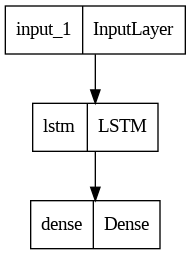

In [20]:
tf.keras.utils.plot_model(model)

In [21]:
r = model.compile(
    loss = 'mse',
    optimizer = 'adam'
)

In [22]:
r = model.fit(
    XTrain,
    YTrain,
    epochs = 100,
    validation_data = (XTest,YTest)
)

Epoch 1/100
4/4 [==============================] - 3s 265ms/step - loss: 0.0111 - val_loss: 0.0108
Epoch 2/100
4/4 [==============================] - 0s 23ms/step - loss: 0.0107 - val_loss: 0.0105
Epoch 3/100
4/4 [==============================] - 0s 21ms/step - loss: 0.0104 - val_loss: 0.0101
Epoch 4/100
4/4 [==============================] - 0s 20ms/step - loss: 0.0102 - val_loss: 0.0098
Epoch 5/100
4/4 [==============================] - 0s 22ms/step - loss: 0.0100 - val_loss: 0.0095
Epoch 6/100
4/4 [==============================] - 0s 21ms/step - loss: 0.0096 - val_loss: 0.0092
Epoch 7/100
4/4 [==============================] - 0s 22ms/step - loss: 0.0094 - val_loss: 0.0087
Epoch 8/100
4/4 [==============================] - 0s 22ms/step - loss: 0.0089 - val_loss: 0.0082
Epoch 9/100
4/4 [==============================] - 0s 31ms/step - loss: 0.0086 - val_loss: 0.0077
Epoch 10/100
4/4 [==============================] - 0s 24ms/step - loss: 0.0080 - val_loss: 0.0070
Epoch 11/100
4/4 [

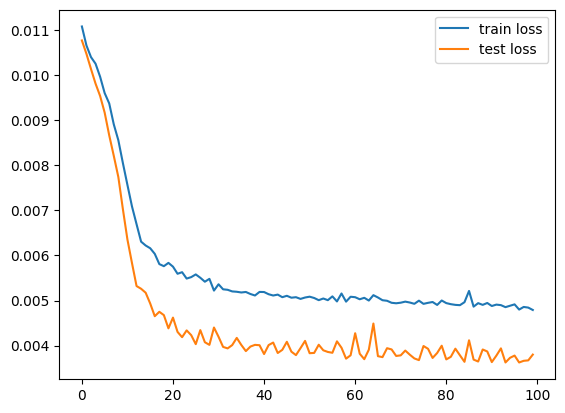

In [23]:
plt.plot(r.history['loss'],label = 'train loss')
plt.plot(r.history['val_loss'],label = 'test loss')
plt.legend();